feature engineering to prepare training data for XGBoost and logistic regression.
1. Build a switcher where I can turn on and off each feature engineering step. In the notebook. should I still build the feature engineering steps on top of each other? i.e. ohe on imputed df.
2. Outliers: We don't want to remove it, leaving them untouched for XGBoost. However, logistic regression is more sensitive to outliers, so we need to handle it.
3. Missing values: XGBoost is good at dealing missing values. However, missing values are still imputed to prepare for other algorithm and compare model performance. 
4. Scaling: scale the data with robust scaler because there are significant outliers, still scaling is not very helpful for xgboost but we add it case we are trying other algorithms.
5. Mutual information evaluation after all the preprocessing to find significant input features. 
6. Build a base model evalution for the dataset, which is evaluated by recall@5% because it's highly imbalanced. 

# 1. Setup

## 1.1 Import libraries and reading data

In [1]:
import yaml
with open ("/Users/zoe/Documents/Bank-account-fraud/params.yaml") as p:
    params = yaml.safe_load(p)
params

{'data_location': '/Users/zoe/Documents/Bank-account-fraud/data',
 'output_location': '/Users/zoe/Documents/Bank-account-fraud/output'}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')

from pylab import rcParams

import seaborn as sns
sns.set_style('whitegrid')
my_palette = sns.color_palette("Paired")

from scipy.stats import chi2_contingency, pearsonr

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2

pd.set_option('display.max_columns', 500)

import warnings as wr
wr.filterwarnings('ignore')


In [116]:
df_base = pd.read_csv(f"{params['data_location']}/Base_backup.csv")
df = df_base.copy()

### Helper functions

In [4]:
# split categorical and numerical features
def split_num_cat(df):
    """
    Function to split columns into two, one having categorical features and another having numerical feautures
    Parameters
    ----------
    df : dataframe
            pass in full dataframe
    ----------
    Returns: 
        a list of categorical features
        a list of numerical features
    """
    categorical_features = []
    numerical_features = []

    for x in df.columns: 
        if df[x].nunique() > 12:
            numerical_features.append(x)
        elif df[x].nunique() >=2:
            categorical_features.append(x)

    if 'fraud_bool' in categorical_features:
        categorical_features.remove('fraud_bool')
    
    return categorical_features, numerical_features

def drop_unnecessary_columns(df, column_name):
    """
    Function to delete the list of columns 
    Parameters
    ----------
    df : dataframe
            pass in full dataframe
    column_name : list
            pass in list of full column
    ----------
    Returns: Dataframe
    """
    df = df.drop(column_name, axis=1)
    return df

## 1.2 Drop features with no variance

In [117]:
constant_feature =[]
for x in df.columns:
    if df[x].nunique() == 1:
        constant_feature.append(x)

print("Constant features:", constant_feature)

Constant features: ['device_fraud_count']


In [118]:
df = drop_unnecessary_columns(df, df[constant_feature])

### 1.3 Change the dataype of binary features into type boolean

In [119]:
binary_features = df.columns[df.nunique() == 2].tolist()

binary_features.remove('source')
# Convert these features"to boolean
df[binary_features] = df[binary_features].astype(bool)

# Verify changes
print(df[binary_features].dtypes)

fraud_bool            bool
email_is_free         bool
phone_home_valid      bool
phone_mobile_valid    bool
has_other_cards       bool
foreign_request       bool
keep_alive_session    bool
dtype: object


## 1.3 Train test split

In [120]:
y = df["fraud_bool"]
X = df.drop(columns=['fraud_bool'], axis = 1)

In [121]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [122]:
X_train.shape

(800000, 30)

In [152]:
y_train.shape

(800000,)

In [12]:
X_train.describe()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.562838,0.493679,16.727529,86.651003,33.683575,1.024581e+00,8.666942,1572.691783,5664.123809,4768.744070,4856.113352,184.627865,9.502435,131.055336,10.847309,516.355675,7.548144,1.018345,3.289231
std,0.290284,0.289083,44.073072,88.428548,12.023340,5.384940e+00,20.255749,1005.553072,3010.204130,1478.809582,919.994441,459.934773,5.033803,69.742814,12.118281,487.806283,8.042752,0.180952,2.209984
min,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1320.283991,2825.748405,0.000000,0.000000,-169.000000,-1.000000,190.000000,-1.000000,-1.000000,0.000000
25%,0.300000,0.225180,-1.000000,19.000000,20.000000,7.183933e-03,-1.181387,894.000000,3435.962936,3592.988203,4268.319057,1.000000,6.000000,83.000000,-1.000000,200.000000,3.102776,1.000000,1.000000
50%,0.600000,0.492253,-1.000000,52.000000,30.000000,1.517071e-02,-0.830680,1263.000000,5317.126477,4749.005380,4913.667485,9.000000,9.000000,122.000000,5.000000,200.000000,5.114818,1.000000,3.000000
75%,0.800000,0.755595,12.000000,130.000000,40.000000,2.632796e-02,4.984334,1943.000000,7681.772107,5750.629217,5487.721416,25.000000,13.000000,178.000000,25.000000,500.000000,8.870898,1.000000,5.000000
max,0.900000,0.999999,381.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16640.749743,9506.896596,6994.764201,2385.000000,39.000000,386.000000,32.000000,2100.000000,83.376775,2.000000,7.000000


In [13]:
categorical_features, numerical_features = split_num_cat(df)
print('Categorical features:', categorical_features)
print('Numerical features:', numerical_features)

Categorical features: ['income', 'customer_age', 'payment_type', 'employment_status', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'month']
Numerical features: ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes']


# 2. Handle missing values¶

XGBoost supports missing values by default. In tree algorithms, branch directions for missing values are learned during training. And the gblinear booster treats missing values as zeros.

We still choose to handle missing values in case of we are using any other types of models. 
Also for features with high percentage of missing values, we choose to add an additional column to indicate where the value is missing, so the model can still learn from missing values. 

In [124]:
# Get names of columns with missing values
missing_value_val = [x for x in X_train.columns if (X_train[x].min() == -1)]

print("Features with missing values represented by -1:")
print(missing_value_val)

# Replace all missing value (-1) with NaN
X_train[missing_value_val] = X_train[missing_value_val].replace(-1, np.nan)
X_test[missing_value_val] = X_test[missing_value_val].replace(-1, np.nan)

Features with missing values represented by -1:
['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']


device_distinct_emails_8w: with median/mean/mode all = 1

session_length_in_minutes: impute with median, skewed to the right

current_address_months_count: impute with median

prev_address_months_count: Longer current address durations correlate with higher missing values in months_in_previous_address, it indicates the missing values are likely not missing at random. Since the missing value correlates with current_address_months_count, use its value as a condition for imputation.

bank_months_count: 
- How old is previous account (if held) in months. Ranges between [−1, 31] months (-1 is a missing value).
- fill with 0s, meaning the previous account doesn't exist.

In [125]:
df_train_imputed = X_train.copy()
df_test_imputed = X_test.copy()

In [126]:
# For features with missing_vals_percentage < 1, impute missing values with the median of the group 
columns_to_impute = ['current_address_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

medians = {}
for column in columns_to_impute:
    medians[column] = df_train_imputed[column].median()

for column in columns_to_impute:
    df_train_imputed[column] = df_train_imputed[column].fillna(medians[column])
    df_test_imputed[column] = df_test_imputed[column].fillna(medians[column])

# Verify no more null values
print((df_train_imputed[columns_to_impute].isna()).sum())
print((df_test_imputed[columns_to_impute].isna()).sum())

current_address_months_count    0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64
current_address_months_count    0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64


In [127]:
# For bank_months_count, fill missing data with 0s 
# add additional column to indicate where missing value is

df_train_imputed['bank_months_count_was_missing'] = df_train_imputed['bank_months_count'].isna().astype(int)
df_test_imputed['bank_months_count_was_missing'] = df_test_imputed['bank_months_count'].isna().astype(int)

df_train_imputed['bank_months_count'] = df_train_imputed['bank_months_count'].fillna(0)
df_test_imputed['bank_months_count'] = df_test_imputed['bank_months_count'].fillna(0)

In [128]:
df_train_imputed.isna().sum()

income                                   0
name_email_similarity                    0
prev_address_months_count           570300
current_address_months_count             0
customer_age                             0
days_since_request                       0
intended_balcon_amount                   0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                        0
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                        0
has_other_cards                          0
proposed_credit_limit                    0
foreign_req

In [129]:
# Impute prev_address_months_count by the median of each current_address_months_count bin bucket
bin_edges = pd.cut(df_train_imputed['current_address_months_count'], 12, retbins=True)[1]

df_train_imputed['current_address_bucket'] = pd.cut(df_train_imputed['current_address_months_count'], bins=bin_edges)
df_test_imputed['current_address_bucket'] = pd.cut(df_test_imputed['current_address_months_count'], bins=bin_edges)

bucket_medians = df_train_imputed.groupby('current_address_bucket')['prev_address_months_count'].median()

df_train_imputed['prev_address_months_count_was_missing'] = df_train_imputed['prev_address_months_count'].isna().astype(int)
df_test_imputed['prev_address_months_count_was_missing'] = df_test_imputed['prev_address_months_count'].isna().astype(int)

df_train_imputed['prev_address_months_count'] = df_train_imputed.groupby('current_address_bucket')['prev_address_months_count'].transform(
    lambda x: x.fillna(x.median())
)

# Impute test set using training bucket medians
df_test_imputed['prev_address_months_count'] = df_test_imputed.apply(
    lambda row: bucket_medians[row['current_address_bucket']] if pd.isna(row['prev_address_months_count']) and row['current_address_bucket'] in bucket_medians else row['prev_address_months_count'], axis=1
)

# Drop the temporary bucket column
df_train_imputed = df_train_imputed.drop("current_address_bucket", axis=1)
df_test_imputed = df_test_imputed.drop("current_address_bucket", axis=1)

In [20]:
df_train_imputed.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
income,800000.0,0.562838,0.290284,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,800000.0,0.493679,0.289083,1.434550e-06,0.225180,0.492253,0.755595,0.999999
prev_address_months_count,800000.0,51.640779,37.007722,5.000000e+00,33.000000,51.000000,56.000000,381.000000
current_address_months_count,800000.0,86.881245,88.270189,0.000000e+00,20.000000,53.000000,130.000000,428.000000
customer_age,800000.0,33.683575,12.023340,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,800000.0,1.024581,5.384940,4.036860e-09,0.007184,0.015171,0.026328,78.456904
intended_balcon_amount,800000.0,8.666942,20.255749,-1.553055e+01,-1.181387,-0.830680,4.984334,112.956928
zip_count_4w,800000.0,1572.691783,1005.553072,1.000000e+00,894.000000,1263.000000,1943.000000,6700.000000
velocity_6h,800000.0,5664.123809,3010.204130,-1.706031e+02,3435.962936,5317.126477,7681.772107,16640.749743
velocity_24h,800000.0,4768.744070,1478.809582,1.320284e+03,3592.988203,4749.005380,5750.629217,9506.896596


In [130]:
# Verify results
print("Train set null values after imputation:")
print((df_train_imputed[missing_value_val].isna()).sum())

print("\nTest set null values after imputation:")
print((df_test_imputed[missing_value_val].isna()).sum())

Train set null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64

Test set null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64


## 3. One-hot encode for categorical features

In [131]:
X_train = df_train_imputed.copy()
X_test = df_test_imputed.copy()

# One-hot encoding for categorical featuers with dtype as 'object'
object_features = [col for col in X_train.columns if X_train[col].dtypes == 'object']
print(object_features)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [132]:
for i in object_features:
    print(i, '\n', X_train[i].unique(), '\n')

payment_type 
 ['AB' 'AC' 'AA' 'AD' 'AE'] 

employment_status 
 ['CD' 'CB' 'CA' 'CF' 'CE' 'CC' 'CG'] 

housing_status 
 ['BB' 'BC' 'BE' 'BA' 'BD' 'BF' 'BG'] 

source 
 ['INTERNET' 'TELEAPP'] 

device_os 
 ['macintosh' 'linux' 'windows' 'other' 'x11'] 



In [133]:
df_train_encoded = X_train.copy()
df_test_encoded = X_test.copy()

In [134]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

ohe_X_train = pd.DataFrame(ohe.fit_transform(df_train_encoded[object_features]))

ohe_X_test = pd.DataFrame(ohe.transform(df_test_encoded[object_features]))

ohe_X_train.index = df_train_encoded.index
ohe_X_test.index = df_test_encoded.index

ohe_feature_names = ohe.get_feature_names_out(input_features=object_features)
ohe_X_train.columns = ohe_feature_names
ohe_X_test.columns = ohe_feature_names

num_X_train = df_train_encoded.drop(object_features, axis=1)
num_X_test = df_test_encoded.drop(object_features, axis=1)

X_train_encoded = pd.concat([num_X_train, ohe_X_train], axis=1)
# X_train = X_train_encoded.drop(object_features, axis=1)
X_test_encoded = pd.concat([num_X_test, ohe_X_test], axis=1)
# X_test = X_test_encoded.drop(object_features, axis=1)

In [135]:
X_train_encoded.columns

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'month', 'bank_months_count_was_missing',
       'prev_address_months_count_was_missing', 'payment_type_AA',
       'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
       'payment_type_AE', 'employment_status_CA', 'employment_status_CB',
       'employment_status_CC', 'employment_status_CD', 'employment_status_CE',
       'employment_status_CF', 'employment_status_CG', 'housing_status_BA',
       'h

In [136]:
X_test_encoded.shape

(200000, 53)

Leave the outliers untouched because we don't want to lose over 50% of positive cases in an extremely imbalanced dataset.

# 4. Binning

Binning the bank_months_count, to turn it into a categorical variable for lower cardinality. 

Don't want to bin any other features as we don't want to lose details of the data 

In [137]:
X_train = X_train_encoded.copy()
X_test = X_test_encoded.copy()

X_train['bank_months_count'].unique()

array([ 1., 10.,  0., 31., 25.,  5., 28., 21., 15., 26., 30., 11., 22.,
       29., 23.,  2., 20.,  6.,  7.,  4., 19., 27.,  3., 16.,  9., 24.,
       18., 14., 12., 32.,  8., 17., 13.])

In [138]:
X_test.shape

(200000, 53)

In [139]:
X_train_binning = X_train_encoded.copy()
X_test_binning = X_test_encoded.copy()

# Define bins where the first bin includes only 0 and the rest are grouped in equal intervals of 4
bins = [0, 1] + [i for i in range(5, 37, 4)] 

# Define the corresponding median values for each bin
median_labels = [0, 2.5, 6.5, 10.5, 14.5, 18.5, 22.5, 26.5, 30.5]

# Bin the 'bank_months_count' feature and replace labels with medians
X_train_binning['bank_months_count_binned'] = pd.cut(
    X_train_binning['bank_months_count'], bins=bins, labels=median_labels, include_lowest=True, right=False
).astype(float)

X_test_binning['bank_months_count_binned'] = pd.cut(
    X_test_binning['bank_months_count'], bins=bins, labels=median_labels, include_lowest=True, right=False
).astype(float)

# Display the bin ranges (as medians) and their respective counts
bin_counts = X_train_binning['bank_months_count_binned'].value_counts().sort_index()

print("Bin medians and counts:")
print(bin_counts)

Bin medians and counts:
bank_months_count_binned
0.0     202886
2.5     186125
6.5      37373
10.5     53539
14.5     51345
18.5     31604
22.5     30427
26.5    119801
30.5     86900
Name: count, dtype: int64


In [140]:
X_train_binning.value_counts().sum()

np.int64(800000)

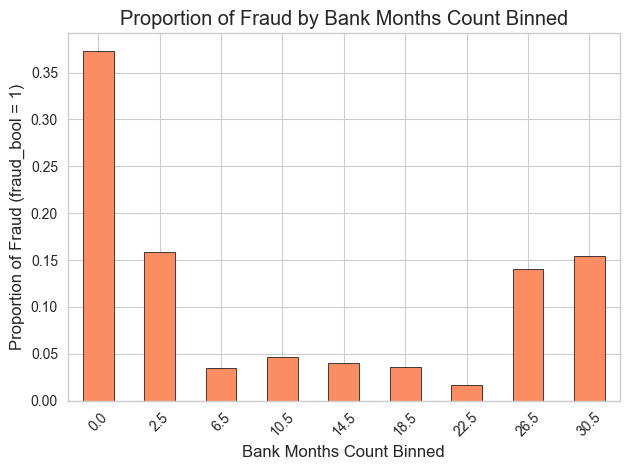

In [141]:
X_train_binning['fraud_bool'] = y_train
fraud_proportion = (
    X_train_binning.groupby('bank_months_count_binned')['fraud_bool']
)

plot_data = (
    X_train_binning[X_train_binning['fraud_bool'] == 1]['bank_months_count_binned']
    .value_counts(normalize=True)
    .sort_index() 
)

# Plot the proportion for fraud_bool = 1
plot_data.plot(kind='bar', color='#fc8d62', edgecolor='black')
plt.xlabel('Bank Months Count Binned')
plt.ylabel('Proportion of Fraud (fraud_bool = 1)')
plt.title('Proportion of Fraud by Bank Months Count Binned')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
X_train_binning = X_train_binning.drop(columns=['fraud_bool'])

In [32]:
X_train_binning.columns

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'month', 'bank_months_count_was_missing',
       'prev_address_months_count_was_missing', 'payment_type_AA',
       'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
       'payment_type_AE', 'employment_status_CA', 'employment_status_CB',
       'employment_status_CC', 'employment_status_CD', 'employment_status_CE',
       'employment_status_CF', 'employment_status_CG', 'housing_status_BA',
       'h

In [142]:
X_train_binning.drop(columns="bank_months_count", inplace=True)
X_test_binning.drop(columns="bank_months_count", inplace=True)

In [143]:
X_train_binning.shape

(800000, 53)

In [144]:
X_test_binning.shape

(200000, 53)

# 5. Scaling

help with unsupervised learning, minimise bias against one variabel 

In [145]:
categorical_features, numerical_features = split_num_cat(X_train_binning)
print('Categorical features:', categorical_features)
print('Numerical features:', numerical_features)

Categorical features: ['income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'month', 'bank_months_count_was_missing', 'prev_address_months_count_was_missing', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'source_INTERNET', 'source_TELEAPP', 'device_os_linux', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'device_os_x11', 'bank_months_count_binned']
Numerical features: ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_re

In [146]:
X_train = X_train_binning.copy()
X_test = X_test_binning.copy()

X_train[numerical_features].describe()

,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,session_length_in_minutes
count,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.493679,51.640779,86.881245,1.024581e+00,8.666942,1572.691783,5664.123809,4768.744070,4856.113352,184.627865,9.502435,131.055336,7.560475
std,0.289083,37.007722,88.270189,5.384940e+00,20.255749,1005.553072,3010.204130,1478.809582,919.994441,459.934773,5.033803,69.742814,8.034326
min,0.000001,5.000000,0.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1320.283991,2825.748405,0.000000,0.000000,-169.000000,0.000872
25%,0.225180,33.000000,20.000000,7.183933e-03,-1.181387,894.000000,3435.962936,3592.988203,4268.319057,1.000000,6.000000,83.000000,3.121877
50%,0.492253,51.000000,53.000000,1.517071e-02,-0.830680,1263.000000,5317.126477,4749.005380,4913.667485,9.000000,9.000000,122.000000,5.123322
75%,0.755595,56.000000,130.000000,2.632796e-02,4.984334,1943.000000,7681.772107,5750.629217,5487.721416,25.000000,13.000000,178.000000,8.870898
max,0.999999,381.000000,428.000000,7.845690e+01,112.956928,6700.000000,16640.749743,9506.896596,6994.764201,2385.000000,39.000000,386.000000,83.376775


### Robust Scaler
https://proclusacademy.com/blog/robust-scaler-outliers/

In [147]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

from sklearn.preprocessing import RobustScaler
 
robust_scaler = RobustScaler()

scaled_train = robust_scaler.fit_transform(X_train_scaled[numerical_features])
scaled_test = robust_scaler.transform(X_test_scaled[numerical_features])

# add new columns scaled features while keeping the original feature with the unscaled values. 
for i, feature in enumerate(numerical_features):
    X_train_scaled['scaled_' + feature] = scaled_train[:, i]
    X_test_scaled['scaled_' + feature] = scaled_test[:, i]

X_train_scaled.describe()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month,bank_months_count_was_missing,prev_address_months_count_was_missing,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,bank_months_count_binned,scaled_name_email_similarity,scaled_prev_address_months_count,scaled_current_address_months_count,scaled_days_since_request,scaled_intended_balcon_amount,scaled_zip_count_4w,scaled_velocity_6h,scaled_velocity_24h,scaled_velocity_4w,scaled_bank_branch_count_8w,scaled_date_of_birth_distinct_emails_4w,scaled_credit_risk_score,scaled_session_length_in_minutes
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,8.000000e+05,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.562838,0.493679,51.640779,86.881245,33.683575,1.024581e+00,8.666942,1572.691783,5664.123809,4768.744070,4856.113352,184.627865,9.502435,131.055336,516.355675,7.560475,1.019105,3.289231,0.253607,0.712875,0.258252,0.370686,0.252069,0.118703,0.000290,0.730457,0.138044,0.037816,0.026511,0.022756,0.043951,0.000464,0.169824,0.260911,0.371921,0.026196,0.169220,0.001677,0.000250,0.992920,0.007080,0.332508,0.053678,0.342805,0.263790,0.007220,11.386696,0.002689,0.027860,0.308011,5.272720e+01,1.540391,0.295226,0.081727,9.148273e-03,-4.719864e-02,7.317828,0.071776,0.095319,0.423925
std,0.290284,0.289083,37.007722,88.270189,12.023340,5.384940e+00,20.255749,1005.553072,3010.204130,1478.809582,919.994441,459.934773,5.033803,69.742814,487.806283,8.034326,0.176621,2.209984,0.435076,0.452421,0.437674,0.482989,0.434201,0.323438,0.017027,0.443722,0.344946,0.190752,0.160650,0.149126,0.204987,0.021530,0.375478,0.439132,0.483318,0.159719,0.374946,0.040923,0.015809,0.083844,0.083844,0.471112,0.225380,0.474647,0.440687,0.084663,11.559845,0.545014,1.609031,0.802456,2.812857e+02,3.285220,0.958583,0.708982,6.853826e-01,7.544634e-01,19.163949,0.719115,0.734135,1.397512
min,0.100000,0.000001,5.000000,0.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1320.283991,2825.748405,0.000000,0.000000,-169.000000,190.000000,0.000872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.928051,-2.000000,-0.481818,-7.924511e-01,-2.384129,-1.203051,-1.292505,-1.589107e+00,-1.712248e+00,-0.375000,-1.285714,-3.063158,-0.891013
25%,0.300000,0.225180,33.000000,20.000000,20.000000,7.183933e-03,-1.181387,894.000000,3435.962936,3592.988203,4268.319057,1.000000,6.000000,8

In [148]:
# drop the original columns before scaling:
X_train_scaled.drop(columns=numerical_features, inplace=True)
X_test_scaled.drop(columns=numerical_features, inplace=True)

In [149]:
X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()

# 5. Handle outliers (optional)

In [41]:
categorical_features, numerical_features = split_num_cat(X_train)
print('Categorical features:', categorical_features)
print('Numerical features:', numerical_features)

Categorical features: ['income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'month', 'bank_months_count_was_missing', 'prev_address_months_count_was_missing', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'source_INTERNET', 'source_TELEAPP', 'device_os_linux', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'device_os_x11', 'bank_months_count_binned']
Numerical features: ['scaled_name_email_similarity', 'scaled_prev_address_months_count', 'scaled_current_address_months_c

In [42]:
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((series < lower_bound) | (series > upper_bound))
    return outliers

total_outliers = X_train[numerical_features].apply(detect_outliers).sum()
outlier_percentage = (total_outliers/len(X_train))*100
outlier_percentage

scaled_name_email_similarity                0.000000
scaled_prev_address_months_count            5.987000
scaled_current_address_months_count         4.142875
scaled_days_since_request                   9.477125
scaled_intended_balcon_amount              22.265250
scaled_zip_count_4w                         6.002250
scaled_velocity_6h                          0.892500
scaled_velocity_24h                         0.299625
scaled_velocity_4w                          0.000000
scaled_bank_branch_count_8w                17.557250
scaled_date_of_birth_distinct_emails_4w     0.978250
scaled_credit_risk_score                    0.874500
scaled_session_length_in_minutes            7.897500
dtype: float64

In [54]:
# For all the fraud cases, what percentage of data is outliers (per feature)
# Filter rows where fraud_bool = 1
X_train_fraud_only = X_train[y_train == 1].copy()
total_outlier_fraud_only= detect_outliers(X_train_fraud_only[numerical_features]).sum()

print(total_outlier_fraud_only)
outlier_percentages_fraud_only = (total_outlier_fraud_only/len(X_train_fraud_only)) *100

print("Percentage of outliers for fraud_bool = 1:")
print(outlier_percentages_fraud_only)

scaled_name_email_similarity                  0
scaled_prev_address_months_count            244
scaled_current_address_months_count         388
scaled_days_since_request                   998
scaled_intended_balcon_amount              1024
scaled_zip_count_4w                         403
scaled_velocity_6h                           95
scaled_velocity_24h                          19
scaled_velocity_4w                            0
scaled_bank_branch_count_8w                1320
scaled_date_of_birth_distinct_emails_4w     179
scaled_credit_risk_score                      3
scaled_session_length_in_minutes            992
dtype: int64
Percentage of outliers for fraud_bool = 1:
scaled_name_email_similarity                0.000000
scaled_prev_address_months_count            2.735426
scaled_current_address_months_count         4.349776
scaled_days_since_request                  11.188341
scaled_intended_balcon_amount              11.479821
scaled_zip_count_4w                         4.517937
sc

In [58]:
# Initialize a dictionary to store the percentage of outliers with fraud_bool = 1 for each feature
outlier_fraud_percentages = {}

# Loop through each numerical feature in X_train
for feature in numerical_features:
    outliers = detect_outliers(X_train[feature])
    fraud_outliers = X_train.loc[outliers & (y_train == 1), feature]
    percentage_fraud_outliers = (len(fraud_outliers) / len(X_train[X_train[feature].notna()])) * 100
    outlier_fraud_percentages[feature] = percentage_fraud_outliers

outlier_fraud_percentages

{'scaled_name_email_similarity': 0.0,
 'scaled_prev_address_months_count': 0.0305,
 'scaled_current_address_months_count': 0.057375,
 'scaled_days_since_request': 0.12375000000000001,
 'scaled_intended_balcon_amount': 0.112875,
 'scaled_zip_count_4w': 0.071125,
 'scaled_velocity_6h': 0.006625,
 'scaled_velocity_24h': 0.000625,
 'scaled_velocity_4w': 0.0,
 'scaled_bank_branch_count_8w': 0.13337500000000002,
 'scaled_date_of_birth_distinct_emails_4w': 0.006125,
 'scaled_credit_risk_score': 0.034999999999999996,
 'scaled_session_length_in_minutes': 0.116375}

No significant association between fraud and outliers. 

In [60]:
X_train_cleaned = X_train.copy()

# Identify outlier rows
outlier_flags = detect_outliers(X_train_cleaned[numerical_features])
outlier_flags
# Detect outliers for numerical features
rows_outliers = outlier_flags.any(axis=1)  # Rows flagged as outliers

# Drop rows with outliers
X_train_cleaned = X_train_cleaned[~rows_outliers]

# Calculate percentage of data retained
percentage_retained = (len(X_train_cleaned) / len(X_train)) * 100

print(f"Percentage of data retained after dropping outliers: {percentage_retained:.2f}%")

Percentage of data retained after dropping outliers: 46.71%


In [61]:
fraud_indices = y_train[y_train == 1].index
fraud_retained = len(fraud_indices.intersection(X_train_cleaned.index))

# The percentage of fraud_bool = 1 retained in X_train after dropping the outliers
percentage_fraud_retained = (fraud_retained / len(fraud_indices)) * 100
print(f"Percentage of fraud_bool = 1 retained in cleaned data: {percentage_fraud_retained:.2f}%")

Percentage of fraud_bool = 1 retained in cleaned data: 53.81%


In [62]:
X_train_cleaned.shape

(373702, 53)

In [63]:
# Ensure y_train has the same indices as X_train_cleaned
y_train_cleaned = y_train.loc[X_train_cleaned.index].copy()

# Handle imbalance with SMOTE, only on the training set

In [150]:
X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()

In [151]:
print(f"Before SMOTE: {Counter(y_train)}")
print("Before SMOTE, shape of the training set", X_train.shape)

Before SMOTE: Counter({False: 791080, True: 8920})
Before SMOTE, shape of the training set (800000, 53)


#### SMOTE NO.1 

In [88]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Oversample the minority class to 30% of the majority class
over = SMOTE(sampling_strategy=0.3, random_state=2)
X_train_res1, y_train_res1 = over.fit_resample(X_train, y_train)

print(f"After SMOTE: {Counter(y_train_res1)}") 

# Undersample the majority class to create a 0.4:1 minority-to-majority ratio
under = RandomUnderSampler(sampling_strategy=0.4, random_state=2)
X_train_res, y_train_res = under.fit_resample(X_train_res1, y_train_res1)

print(f"After RandomUnderSampler: {Counter(y_train_res)}")
print("After RandomUnderSampler, shape of the training set", X_train_res.shape)

After SMOTE: Counter({0: 791080, 1: 237324})
After RandomUnderSampler: Counter({0: 593310, 1: 237324})
After RandomUnderSampler, shape of the training set (830634, 53)


#### SMOTE NO.2

In [167]:
over = SMOTE(sampling_strategy=0.5, random_state=2)
X_train_res3, y_train_res3 = over.fit_resample(X_train, y_train)

print(f"After SMOTE: {Counter(y_train_res3)}") 

# Undersample the majority class to create a 0.8:1 minority-to-majority ratio
under = RandomUnderSampler(sampling_strategy=0.8, random_state=2)
X_train_res4, y_train_res4 = under.fit_resample(X_train_res3, y_train_res3)

print(f"After RandomUnderSampler: {Counter(y_train_res4)}")
print("After RandomUnderSampler, shape of the training set", X_train_res4.shape)

After SMOTE: Counter({0: 791080, 1: 395540})
After RandomUnderSampler: Counter({0: 494425, 1: 395540})
After RandomUnderSampler, shape of the training set (889965, 53)


In [ ]:
X_train_res4.to_csv("../data/x_train_data_smote.csv", index=True)
y_train_res4.to_csv("../data/y_train_data_smote.csv")

#### SMOTE NO.3

In [178]:
over = SMOTE(sampling_strategy=1, random_state=2)
X_train_res5, y_train_res5 = over.fit_resample(X_train, y_train)

print(f"After SMOTE: {Counter(y_train_res5)}") 

# Undersample the majority class to create a 1:1 minority-to-majority ratio
under = RandomUnderSampler(sampling_strategy=1, random_state=2)
X_train_res6, y_train_res6 = under.fit_resample(X_train_res5, y_train_res5)

print(f"After RandomUnderSampler: {Counter(y_train_res6)}")
print("After RandomUnderSampler, shape of the training set", y_train_res6.shape)

After SMOTE: Counter({0: 791080, 1: 791080})
After RandomUnderSampler: Counter({0: 791080, 1: 791080})
After RandomUnderSampler, shape of the training set (1582160,)


In [170]:
X_train_res6.to_csv("../data/x_train_data_smote3.csv", index=True)

y_train_res6.to_csv("../data/y_train_data_smote3.csv")

In [177]:
y_train.shape

(800000,)

# Feature Selection

## Mutual Information

In [64]:
X = X_train.copy()
y = y_train.copy()

# Label encoding for categoricals
for colname in X.select_dtypes(["category", "object"]):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [65]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores 

device_os_windows                          0.003548
housing_status_BA                          0.003248
scaled_current_address_months_count        0.003108
scaled_credit_risk_score                   0.002552
income                                     0.002376
proposed_credit_limit                      0.002286
email_is_free                              0.002235
prev_address_months_count_was_missing      0.002132
has_other_cards                            0.002072
scaled_date_of_birth_distinct_emails_4w    0.001972
phone_home_valid                           0.001738
employment_status_CA                       0.001730
customer_age                               0.001722
keep_alive_session                         0.001375
payment_type_AA                            0.001313
scaled_bank_branch_count_8w                0.001195
housing_status_BC                          0.001176
source_INTERNET                            0.001114
employment_status_CE                       0.001091
payment_type

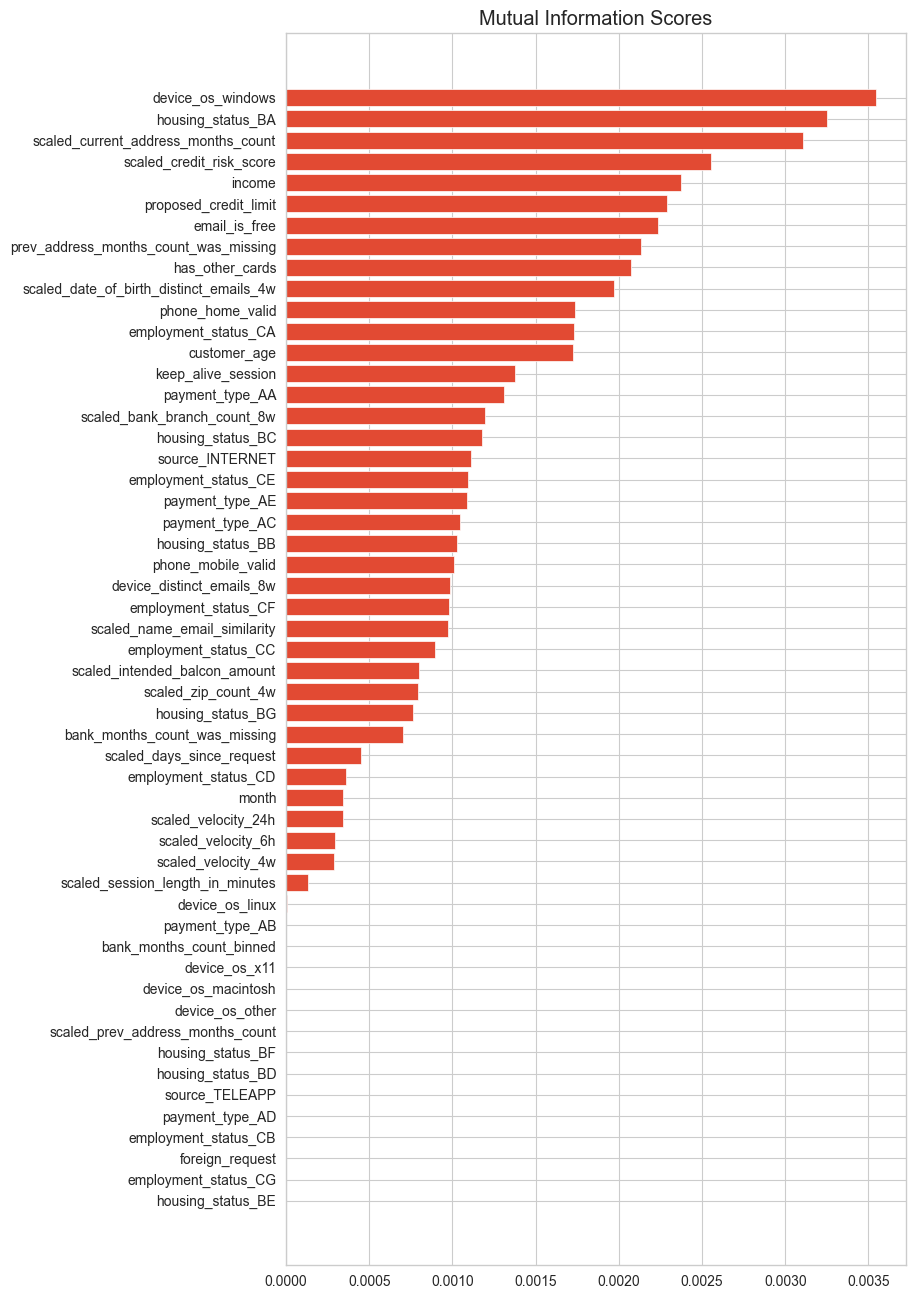

In [66]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 16))
plot_mi_scores(mi_scores)

MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

                                  feature    chi2_score        p_value
1                            customer_age  1.386932e+04   0.000000e+00
25                      housing_status_BA  8.739463e+03   0.000000e+00
37                      device_os_windows  3.714831e+03   0.000000e+00
6                   proposed_credit_limit  1.770965e+06   0.000000e+00
8                      keep_alive_session  8.735908e+02  5.407087e-192
34                        device_os_linux  8.608609e+02  3.165200e-189
5                         has_other_cards  7.581747e+02  6.697868e-167
36                        device_os_other  7.212952e+02  6.998634e-159
29                      housing_status_BE  7.182984e+02  3.138047e-158
27                      housing_status_BC  6.564961e+02  8.636515e-145
13                        payment_type_AA  6.540571e+02  2.929354e-144
20                   employment_status_CC  6.035286e+02  2.859602e-133
15                        payment_type_AC  5.953800e+02  1.693116e-131
3     

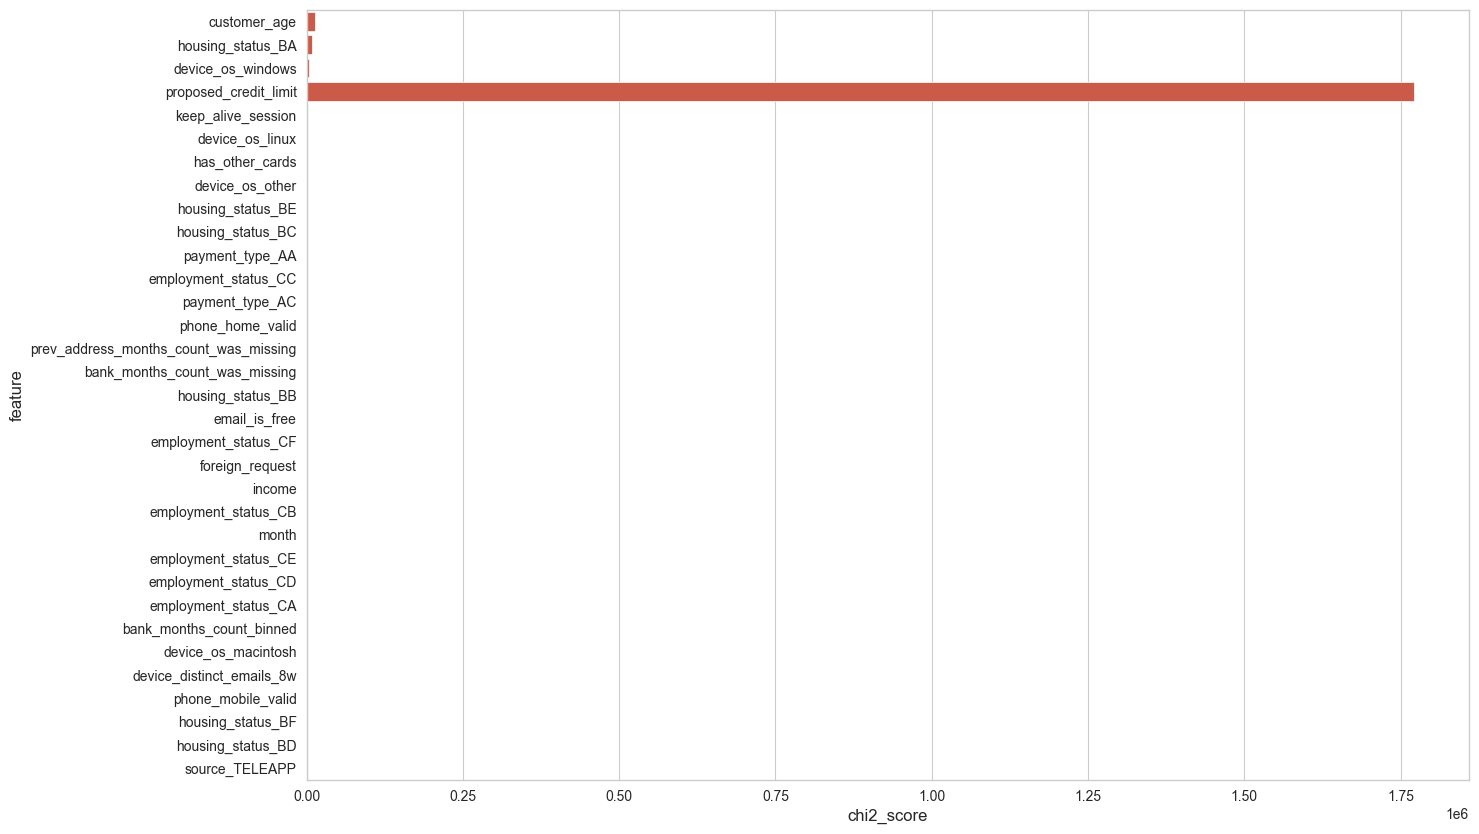

In [116]:
from sklearn.feature_selection import chi2, SelectKBest

x = X_train[categorical_features]
y = y_train

chi2_test = SelectKBest(score_func=chi2).fit(x, y)

chi2_output = pd.DataFrame()
chi2_output['feature'] = x.columns
chi2_output['chi2_score'] = chi2_test.scores_
chi2_output['p_value'] = chi2_test.pvalues_
chi2_output = chi2_output.sort_values(by=['p_value'])

print(chi2_output)

chi2_output_significant = chi2_output[chi2_output['p_value'] <= 0.05]

plt.figure(figsize=(15, 10))
sns.barplot(data = chi2_output_significant, x = 'chi2_score', y = 'feature' )
plt.show()

# for feature in categorical_features:
#     contingency_table = pd.crosstab(X_train[feature], y_train)
#     chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
#     # Store the Chi-Squared value
#     chi_squared_values[feature] = chi2

# # Convert the dictionary to a DataFrame for easy plotting
# chi_squared_df = pd.DataFrame(list(chi_squared_values.items()), columns=['Feature', 'Chi-Squared Value'])
# chi_squared_df
# # Plot the Chi-Squared values
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Chi-Squared Value', y='Feature', data=chi_squared_df, color='#93cb8d')
# plt.title('Chi-Squared Value by Categorical Feature')
# plt.xlabel('Chi-Squared Value')
# plt.ylabel('Feature')
# plt.tight_layout()
# plt.show()

# Creating Features

Tips on Creating Features

It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:

Linear models learn sums and differences naturally, but can't learn anything more complex.
Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.

Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once. 

# Target Encoding

# Finalize data for training

In [171]:
bool_features = [col for col in X_train.columns if X_train[col].dtypes == 'bool']
X_train[bool_features] = X_train[bool_features].astype("int")

In [172]:
X_train[bool_features] = X_train[bool_features].astype("int")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 566853 to 121958
Data columns (total 53 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   income                                   800000 non-null  float64
 1   customer_age                             800000 non-null  int64  
 2   email_is_free                            800000 non-null  int64  
 3   phone_home_valid                         800000 non-null  int64  
 4   phone_mobile_valid                       800000 non-null  int64  
 5   has_other_cards                          800000 non-null  int64  
 6   proposed_credit_limit                    800000 non-null  float64
 7   foreign_request                          800000 non-null  int64  
 8   keep_alive_session                       800000 non-null  int64  
 9   device_distinct_emails_8w                800000 non-null  float64
 10  month                           

In [173]:
y_train = y_train.astype("int")
y_train.info()

<class 'pandas.core.series.Series'>
Index: 800000 entries, 566853 to 121958
Series name: fraud_bool
Non-Null Count   Dtype
--------------   -----
800000 non-null  int64
dtypes: int64(1)
memory usage: 12.2 MB


In [174]:
X_test[bool_features] = X_test[bool_features].astype("int")
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 987231 to 390499
Data columns (total 53 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   income                                   200000 non-null  float64
 1   customer_age                             200000 non-null  int64  
 2   email_is_free                            200000 non-null  int64  
 3   phone_home_valid                         200000 non-null  int64  
 4   phone_mobile_valid                       200000 non-null  int64  
 5   has_other_cards                          200000 non-null  int64  
 6   proposed_credit_limit                    200000 non-null  float64
 7   foreign_request                          200000 non-null  int64  
 8   keep_alive_session                       200000 non-null  int64  
 9   device_distinct_emails_8w                200000 non-null  float64
 10  month                           

In [175]:
y_test = y_test.astype("int")
y_test.info()

<class 'pandas.core.series.Series'>
Index: 200000 entries, 987231 to 390499
Series name: fraud_bool
Non-Null Count   Dtype
--------------   -----
200000 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB


In [176]:
X_train.to_csv("../data/x_train_data.csv", index=True)
X_test.to_csv("../data/x_test_data.csv")

y_train.to_csv("../data/y_train_data.csv")
y_test.to_csv("../data/y_test_data.csv")

# Baseline model

In [84]:
# imbalaned dataset with low percentage of positive cases
# use AUC as the measuring metrics
# assume it's more costly to have higher FN(misclassified fraud cases as not fraud) than higher FP (false alarm for not fraud as fraud).

In [130]:
from sklearn.metrics import roc_auc_score, confusion_matrix

def baseline_model_score(X, y, model):
    """
    Function to compute the AUC of the baseline model and compare FN and FP costs.
    
    Parameters:
        X: DataFrame with the training features
        y: Series with the true labels (fraud_bool)
        model: The model to be evaluated (must have a 'predict_proba' method)
        
    Returns:
        auc_score: AUC score of the model
        fn_cost: The number of false negatives for the given model
        fp_cost: The number of false positives for the given model
    """
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
        
    model.fit(X, y)
    
    # Predict probabilities of the positive class (fraud) using the model
    probs = model.predict_proba(X)[:, 1]
    
    # AUC score
    auc_score = roc_auc_score(y, probs)
    
    # Predicted classes using a threshold of 0.5
    y_pred = (probs >= 0.5).astype(int)
    
    # Confusion matrix (True Positives, False Positives, False Negatives, True Negatives)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fpr, tpr, thresholds = roc_curve(y, probs)
    
    # Cost is defined as FN being more costly than FP
    fn_cost = fn
    fp_cost = fp
    
    print(f"AUC: {auc_score:.4f}")
    print(f"False Negatives (FN): {fn}")
    print(f"False Positives (FP): {fp}")
    
    return auc_score, fn_cost, fp_cost, fpr, tpr, thresholds

In [131]:
model = XGBClassifier()
auc_score, fn_cost, fp_cost, fpr, tpr, thresholds = baseline_model_score(X_train, y_train, model=model)

AUC: 0.9537
False Negatives (FN): 8018 
False Positives (FP): 185


In [127]:
fpr = pd.DataFrame(fpr)
fpr[0:50]

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000001
4,0.000001
5,0.000003
6,0.000003
7,0.000004
8,0.000004
9,0.000005


In [126]:
tpr[0:50]

array([0.        , 0.00011211, 0.00459641, 0.00459641, 0.00762332,
       0.00762332, 0.01154709, 0.01154709, 0.01244395, 0.01244395,
       0.01401345, 0.01401345, 0.01434978, 0.01434978, 0.01502242,
       0.01502242, 0.01748879, 0.01748879, 0.01793722, 0.01793722,
       0.01816143, 0.01816143, 0.01961883, 0.01961883, 0.02017937,
       0.02017937, 0.02096413, 0.02096413, 0.02275785, 0.02275785,
       0.0235426 , 0.0235426 , 0.02365471, 0.02365471, 0.025     ,
       0.025     , 0.02533632, 0.02533632, 0.02769058, 0.02769058,
       0.0308296 , 0.0308296 , 0.03116592, 0.03116592, 0.03172646,
       0.03172646, 0.03307175, 0.03307175, 0.03329596, 0.03329596])

In [128]:
thresholds = pd.DataFrame(thresholds)
thresholds[0:50]

,0
0,inf
1,0.984188
2,0.864253
3,0.863094
4,0.840160
5,0.839960
6,0.808939
7,0.808445
8,0.804869
9,0.804016
